In [ ]:
# flag to modify everything to run better on Colab; change it to true if you want to run on colab
use_colab = True
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/CS-4476/CS4476-Project5')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Camvid			   initmodel		     setup.cfg
conda			   kitti		     src
dataset_lists		   proj5_colab.ipynb	     tests
doc			   proj5_local.ipynb	     train_epoch_40
download_dataset.sh	   pyproject.toml	     zip_for_colab.py
exp			   README.md		     zip_submission.py
grayscale_predictions.zip  rzhang662@gatech.edu.zip


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/CS-4476/CS4476-Project5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Running setup.py develop for vision


# [Semantic Segmentation with Deep Learning](https://www.cc.gatech.edu/~hays/compvision/proj6/)

For this project we are going to focus on semantic segmentation for 11 semantic categories with a state-of-the-art approach: deep learning.

Basic learning objectives of this project:

1. Understanding the ResNet architecture.
2. Understand the concepts behind data augmentation and learning rate schedules for semantic segmentation
3. Understand the role of dilated convolution and context in increasing the receptive field of a network.
4. Experiment with different aspects of the training process and observe the performance.

The starter code is mostly initialized to 'placeholder' just so that the starter code does not crash when run unmodified and you can get a preview of how results are presented.

Your trained model should be able to produce an output like the one shown on the right below:

Camvid Image | Model Prediction
:-: | :--:
<img src="https://user-images.githubusercontent.com/16724970/114431741-d6b7dd00-9b8d-11eb-8822-e7fa7e915e37.jpg" width="300"> | <img src="https://user-images.githubusercontent.com/16724970/114431739-d61f4680-9b8d-11eb-9266-e56aeb08476f.jpg" width="300">


## PSPNet and ResNet-50

We'll be implementing PSPNet for this project, which uses a ResNet-50 backbone. ResNet-50 has 50 convolutional layers, which is significantly deeper than your SimpleNet of Project 5. We give you the implementation in `src/vision/resnet.py`. 

The ResNet-50 is composed of 4 different sections (each called a "layer"), named `layer1`, `layer2`, `layer3`, `layer4`. Each layer is composed of a repeated number of blocks, and each such block is named a `BottleNeck`. Specifically, `layer1` has 3 Bottlenecks, `layer2` has 4 Bottlenecks, `layer3` has 6 Bottlenecks, and `layer4` has 3 Bottlenecks. In all, ResNet-50 has 16 Bottlenecks, which accounts for 48 of the conv layers.

### Visualizing a ResNet Bottleneck Module

The BottleNeck has a residual connection, from which ResNet gets its name:

<img width="300" src="https://user-images.githubusercontent.com/16724970/114430171-2ac1c200-9b8c-11eb-8341-fc943ff0945f.png">

See Figure 5 of the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf)

### Implementing a Bottleneck

The Bottleneck is implemented exactly as the figure above shows, with 1x1 Conv -> BN -> ReLU -> 3x3 Conv -> BN -> ReLU -> 1x1 Conv -> BN -> Optional Downsample -> Add Back Input -> ReLU. The channel dimension of the feature map will be expanded by 4x, as we can see by the conv layer `in_features` and `out_features` parameters. And notice that the stride is set at the `conv2` module, which will be very important later.

```python
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
```

and the forward method of the `Bottleneck` shows the residual connection. Notice that when we add back the input (the identity operation), we may need to downsample it for the shapes to match during the add operation (if the main branch downsampled the input):
```python
    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
```

## Visualizing the Architecture
Plotting the whole network architecture would require a massive figure, but we can show how data flows through just one Bottleneck, starting with 64 channels, and ending up with 256 output channels:
<p float="left">
  <img src="https://user-images.githubusercontent.com/16724970/114427960-9eae9b00-9b89-11eb-9a3b-96817f205f32.png" width="400" />
</p>


## Part 1: Pyramid Pooling Module
In Part 1, you will implement the Pyramid Pooling Module (PPM). After feeding an image through the ResNet backbone and obtaining a feature map, PSPNet aggregates context over different portions of the image with the PPM.

The PPM splits the $H \times W$ feature map into KxK grids. Here, 1x1, 2x2, 3x3,and 6x6 grids are formed, and features are average-pooled within each grid cell. Afterwards, the 1x1, 2x2, 3x3, and 6x6 grids are upsampled back to the original $H \times W$ feature map resolution, and are stacked together along the channel dimension. These grids are visualized below (center):

<img src="https://user-images.githubusercontent.com/16724970/114436422-4b414a80-9b93-11eb-8f02-8e7506b5f9a1.jpg" width="900">

Implement this in `src/vision/part1_ppm.py`.

In [ ]:
%load_ext autoreload
%autoreload 2
from tests.test_part1_ppm import test_PPM_6x6, test_PPM_fullres
from src.vision.utils import verify

print("test_PPM_6x6(): ", verify(test_PPM_6x6))
print("test_PPM_fullres(): ", verify(test_PPM_fullres))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
test_PPM_6x6():  "Correct"
test_PPM_fullres():  "Correct"


## Part 2: Dataset and Dataloader
Next, in `src/vision/part2_dataset.py` you will implement the `make_dataset()` functions to create a list of paths to (image, ground truth) pairs. You will also implement the `__getitem__()` function that will load an RGB image and grayscale label map, and then apply a transform to them.

In [ ]:
!ls /content/drive/MyDrive/CS-4476/CS4476-Project5/tests/test_data/CamvidSubsampled

701_StillsRaw_full  semseg11


In [ ]:
from tests.test_part2_dataset import test_SemData_len, test_getitem_no_data_aug, test_make_dataset

print("test_SemData_len(): ", verify(test_SemData_len))
print("test_getitem_no_data_aug(): ", verify(test_getitem_no_data_aug))
print("test_make_dataset(): ", verify(test_make_dataset))

[('/content/drive/MyDrive/CS-4476/CS4476-Project5/tests/test_data/CamvidSubsampled/701_StillsRaw_full/0001TP_006690.png', '/content/drive/MyDrive/CS-4476/CS4476-Project5/tests/test_data/CamvidSubsampled/semseg11/0001TP_006690_L.png'), ('/content/drive/MyDrive/CS-4476/CS4476-Project5/tests/test_data/CamvidSubsampled/701_StillsRaw_full/0001TP_006720.png', '/content/drive/MyDrive/CS-4476/CS4476-Project5/tests/test_data/CamvidSubsampled/semseg11/0001TP_006720_L.png'), ('/content/drive/MyDrive/CS-4476/CS4476-Project5/tests/test_data/CamvidSubsampled/701_StillsRaw_full/0001TP_006750.png', '/content/drive/MyDrive/CS-4476/CS4476-Project5/tests/test_data/CamvidSubsampled/semseg11/0001TP_006750_L.png')]
List of (image,label) pairs train list generated!
test_SemData_len():  "Correct"
[('/content/drive/MyDrive/CS-4476/CS4476-Project5/tests/test_data/CamvidSubsampled/701_StillsRaw_full/0001TP_006690.png', '/content/drive/MyDrive/CS-4476/CS4476-Project5/tests/test_data/CamvidSubsampled/semseg11/0001

## Part 3: Online Data Preprocessing and Data Augmentation
Data preprocessing and augmentation is very important to good performance, and we'll implement this in `src/vision/part3_training_utils.py`. We'll feed in square image crops to the network, but we must be careful to crop the same portion of the RGB image and ground truth semantic label map. Implement `get_train_transform(args)` and `get_val_transform(args)`, and check against the unit tests below:


In [ ]:
from tests.test_part3_training_utils import test_get_train_transform, test_get_val_transform

print("test_get_train_transform(): ", verify(test_get_train_transform))
print("test_get_val_transform(): ", verify(test_get_val_transform))

test_get_train_transform():  "Correct"
test_get_val_transform():  "Correct"


In [ ]:
import src.vision.cv2_transforms

## Part 4: A Simple Segmentation Baseline
We'll start with a very simple baseline -- a pretrained ResNet-50, without the final averagepool/fc layer, and a single 1x1 conv as a final classifier, converting the (2048,7,7) feature map to scores over 11 classes, a (11,7,7) tensor. Note that our output is just 7x7, which is very low resolution. Implement upsampling to the original height and width, and compute the loss and predicted class per pixel in `src/vision/part4_segmentation_net.py`.

If the "SimpleSegmentationNet" architecture is specified in the experiment arguments (`args`), return this model in `get_model_and_optimizer()` in `part3_training_utils.py`.

In [ ]:
!ls
!mkdir initmodel && mv resnet50_v2.pth initmodel

Camvid		     exp		pyproject.toml	 tests
conda		     initmodel		README.md	 vision
dataset_lists	     kitti		resnet50_v2.pth  zip_for_colab.py
doc		     proj5_colab.ipynb	setup.cfg	 zip_submission.py
download_dataset.sh  proj5_local.ipynb	src
mkdir: cannot create directory ‘initmodel’: File exists


In [ ]:
import src.vision.part3_training_utils
import src.vision.part1_ppm
import src.vision.part4_segmentation_net
import src.vision.part5_pspnet

In [ ]:
from torch import nn
from src.vision.resnet import resnet50
model = resnet50(pretrained=True, deep_base=True)
# print(model.layer2[0])
list(model.children())[0:8]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [ ]:
import vision.part3_training_utils
import vision.part4_segmentation_net

In [ ]:
from tests.test_part4_segmentation_net import (
    test_check_output_shapes,
    test_check_output_shapes_testtime,
    test_get_model_and_optimizer_simplearch
)

print("test_check_output_shapes(): ", verify(test_check_output_shapes))
print("test_check_output_shapes_testtime(): ", verify(test_check_output_shapes_testtime))
print("test_get_model_and_optimizer_simplearch(): ", verify(test_get_model_and_optimizer_simplearch))

test_check_output_shapes():  "Correct"
test_check_output_shapes_testtime():  "Correct"
namespace(arch='SimpleSegmentationNet', base_lr=0.001, classes=11, ignore_label=255, layers=50, momentum=0.99, pretrained=False, weight_decay=1e-05, zoom_factor=8)
test_get_model_and_optimizer_simplearch():  "Correct"


## Part 5: Net Surgery for Increased Output Resolution and Receptive Field
The basic ResNet-50 has two major problems:
1. It does not have a large enough receptive field
2. If run fully-convolutionally, it produces a low-resolution output (just $7 \times 7$)!

To fix the first problem, will need to replace some of its convolutional layers with dilated convolution. To fix the second problem, we'll reduce the stride of the network from 2 to 1, so that we don't downsample so much. Instead of going down to 7x7, we'll reduce to 28x28 for 224x224 input, or 26x26 for 201x201, like we do in this project. In other words, the downsampling rate will go from (1/32) to just (1/8).

These animations depict how the dilated convolution (i.e. with dilation > 1) operation compares to convolution with no dilation (i.e. with dilation=1).

Conv w/ Stride=1, Dilation=1 | Conv w/ Stride=2, Dilation=1 | Conv w/ Stride=1, Dilation=2
:-: | :-: | :-:
<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif" width="300" align="center"> | <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif" width="300" align="center"> | <img src="https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/dilation.gif" width="300" align="center"> 


In Layer3, in every `Bottleneck`, we will change the 3x3 `conv2`, we will replace the conv layer that had stride=2, dilation=1, and padding=1 with a new conv layer, that instead  has stride=1, dilation=2, and padding=2. In the `downsample` block, we'll also need to hardcode the stride to 1, instead of 2.

In Layer4, for every `Bottleneck`, we will make the same changes, except we'll change the dilation to 4 and padding to 4.

Make these edits in `src/vision/part5_pspnet.py`.

In [ ]:
import vision.part5_pspnet

In [ ]:
from tests.test_part5_pspnet import (
    test_pspnet_output_shapes,
    test_check_output_shapes_testtime_pspnet,
    test_get_model_and_optimizer_pspnet,
    test_pspnet_output_with_zoom_factor
)

print("test_pspnet_output_shapes():", verify(test_pspnet_output_shapes))
print("test_check_output_shapes_testtime_pspnet(): ", verify(test_check_output_shapes_testtime_pspnet))
print("test_check_output_shapes_zoom_factor_testtime_pspnet(): ", verify(test_pspnet_output_with_zoom_factor))

test_pspnet_output_shapes(): "Correct"
test_check_output_shapes_testtime_pspnet():  "Correct"
test_check_output_shapes_zoom_factor_testtime_pspnet():  "Correct"


In [ ]:
print("test_get_model_and_optimizer_pspnet(): ", verify(test_get_model_and_optimizer_pspnet))

namespace(arch='PSPNet', base_lr=0.001, classes=11, ignore_label=255, layers=50, momentum=0.99, pretrained=False, use_ppm=True, weight_decay=1e-05, zoom_factor=8)
test_get_model_and_optimizer_pspnet():  "Correct"


## Part 6 Transfer Learning

This section is required for CS 6476 students and optional for CS 4476.

Use the model trained on Camvid as a pretrained model, and train it on Kitti Dataset. The Kitti dataloader is provided. Finish the model_and_optimizer function in part 6.  



In [ ]:
from tests.test_part6_kitti_dataset import test_model_kitti
print("test_model_kitti():", verify(test_model_kitti))

In [ ]:
! rm -r initmodel

In [ ]:
!ls -ltrh initmodel

In [ ]:
!chmod +rwx download_dataset.sh
!sed -i -e 's/\r$//' download_dataset.sh
!./download_dataset.sh Camvid

In [ ]:
!ls
!cd Camvid && unzip camvid_semseg11.zip && cd ..

In [ ]:
# flag to modify everything to run better on Colab; change it to true if you want to run on colab
use_colab = True
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/CS-4476/CS4476-Project5')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Camvid			   initmodel		     setup.cfg
conda			   kitti		     src
dataset_lists		   proj5_colab.ipynb	     tests
doc			   proj5_local.ipynb	     train_epoch_10
download_dataset.sh	   pyproject.toml	     zip_for_colab.py
exp			   README.md		     zip_submission.py
grayscale_predictions.zip  rzhang662@gatech.edu.zip


In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/CS-4476/CS4476-Project5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Running setup.py develop for vision


In [ ]:
from types import SimpleNamespace

args = SimpleNamespace(
    **{
        # DATA
        "names_path": "./dataset_lists/camvid-11/camvid-11_names.txt",
        "data_root": "./Camvid/",
        "train_list": "./src/dataset_lists/camvid-11/list/train.txt",  
        "val_list": "./src/dataset_lists/camvid-11/list/val.txt",
        "classes": 11,
        # TRAIN
        "arch": "SimpleSegmentationNet",#"PSPNet", #  "SimpleSegmentationNet", # 
        "save_path": "",
        "epochs": 10,
        "zoom_factor": 8,
        "use_ppm": True,
        "aux_weight": 0.4,
        "aux_loss": True,
        "layers": 50,
        "workers": 2,
        "batch_size": 32,
        "batch_size_val": 32,
        "data_aug": True,
        "short_size": 240,
        "train_h": 201,
        "train_w": 201,
        "init_weight": "./initmodel/resnet50_v2.pth",
        "scale_min": 0.5,  # minimum random scale
        "scale_max": 2.0,  # maximum random scale
        "rotate_min": -10,  # minimum random rotate
        "rotate_max": 10,  # maximum random rotate
        "ignore_label": 255,
        "base_lr": 0.01,
        "start_epoch": 0,
        "power": 0.9,
        "momentum": 0.9,
        "weight_decay": 0.0001,
        "manual_seed": 0,
        "print_freq": 5,
        "save_freq": 5,
        "evaluate": True,  # evaluate on validation set, extra gpu memory needed and small batch_size_val is recommend
        "multiprocessing_distributed": False,
        # INFERENCE
        "dataset": "camvid-11",
        "base_size": 240,
        "test_h": 201,
        "test_w": 201,
        "scales": [1.0], # [0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        "test_list": "./src/dataset_lists/camvid-11/list/val.txt",
        "vis_freq": 5,
        "pretrained": False
    }
)

args.save_path = f"exp/camvid/{args.arch}/model"

In [ ]:
import src.vision.part3_training_utils

In [ ]:
import os

import torch

os.makedirs(args.save_path, exist_ok=True)
from src.vision.trainer import main_worker
print(args)
main_worker(args, torch.cuda.is_available())

namespace(arch='SimpleSegmentationNet', aux_loss=True, aux_weight=0.4, base_lr=0.01, base_size=240, batch_size=32, batch_size_val=32, classes=11, data_aug=True, data_root='./Camvid/', dataset='camvid-11', epochs=10, evaluate=True, ignore_label=255, init_weight='./initmodel/resnet50_v2.pth', layers=50, manual_seed=0, momentum=0.9, multiprocessing_distributed=False, names_path='./dataset_lists/camvid-11/camvid-11_names.txt', power=0.9, pretrained=False, print_freq=5, rotate_max=10, rotate_min=-10, save_freq=5, save_path='exp/camvid/SimpleSegmentationNet/model', scale_max=2.0, scale_min=0.5, scales=[1.0], short_size=240, start_epoch=0, test_h=201, test_list='./src/dataset_lists/camvid-11/list/val.txt', test_w=201, train_h=201, train_list='./src/dataset_lists/camvid-11/list/train.txt', train_w=201, use_ppm=True, val_list='./src/dataset_lists/camvid-11/list/val.txt', vis_freq=5, weight_decay=0.0001, workers=2, zoom_factor=8)
namespace(arch='SimpleSegmentationNet', aux_loss=True, aux_weight=

INFO:main-logger:namespace(arch='SimpleSegmentationNet', aux_loss=True, aux_weight=0.4, base_lr=0.01, base_size=240, batch_size=32, batch_size_val=32, classes=11, data_aug=True, data_root='./Camvid/', dataset='camvid-11', epochs=10, evaluate=True, ignore_label=255, init_weight='./initmodel/resnet50_v2.pth', layers=50, manual_seed=0, momentum=0.9, multiprocessing_distributed=False, names_path='./dataset_lists/camvid-11/camvid-11_names.txt', power=0.9, pretrained=False, print_freq=5, rotate_max=10, rotate_min=-10, save_freq=5, save_path='exp/camvid/SimpleSegmentationNet/model', scale_max=2.0, scale_min=0.5, scales=[1.0], short_size=240, start_epoch=0, test_h=201, test_list='./src/dataset_lists/camvid-11/list/val.txt', test_w=201, train_h=201, train_list='./src/dataset_lists/camvid-11/list/train.txt', train_w=201, use_ppm=True, val_list='./src/dataset_lists/camvid-11/list/val.txt', vis_freq=5, weight_decay=0.0001, workers=2, zoom_factor=8)


[2022-12-08 19:54:56,793 INFO trainer.py line 60 9470] => creating model ...


INFO:main-logger:=> creating model ...


[2022-12-08 19:54:56,799 INFO trainer.py line 61 9470] Classes: 11


INFO:main-logger:Classes: 11


===no aug===
[('./Camvid/701_StillsRaw_full/0001TP_006690.png', './Camvid/semseg11/0001TP_006690_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006720.png', './Camvid/semseg11/0001TP_006720_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006750.png', './Camvid/semseg11/0001TP_006750_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006780.png', './Camvid/semseg11/0001TP_006780_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006810.png', './Camvid/semseg11/0001TP_006810_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006840.png', './Camvid/semseg11/0001TP_006840_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006870.png', './Camvid/semseg11/0001TP_006870_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006900.png', './Camvid/semseg11/0001TP_006900_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006930.png', './Camvid/semseg11/0001TP_006930_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006960.png', './Camvid/semseg11/0001TP_006960_L.png'), ('./Camvid/701_StillsRaw_full/0001TP_006990.png', './Camvid/semseg

INFO:main-logger:train Epoch: [1/10][5/11] mIoU 0.06613732129335403 Data 1.076 (0.759) Batch 1.515 (1.205) Remain 00:02:06 MainLoss 1.9697 AuxLoss 0.0000 Loss 1.9697 


[2022-12-08 19:55:07,097 INFO trainer.py line 356 9470] train Epoch: [1/10][10/11] mIoU 0.06424596905708313 Data 0.000 (0.580) Batch 0.434 (1.024) Remain 00:01:42 MainLoss 1.9760 AuxLoss 0.0000 Loss 1.9760 


INFO:main-logger:train Epoch: [1/10][10/11] mIoU 0.06424596905708313 Data 0.000 (0.580) Batch 0.434 (1.024) Remain 00:01:42 MainLoss 1.9760 AuxLoss 0.0000 Loss 1.9760 


[2022-12-08 19:55:08,022 INFO trainer.py line 361 9470] Train result at epoch [1/10]: mIoU/mAcc/allAcc 0.0636/0.1218/0.3930.


INFO:main-logger:Train result at epoch [1/10]: mIoU/mAcc/allAcc 0.0636/0.1218/0.3930.


[2022-12-08 19:55:12,867 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0292/0.0909/0.3211.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0292/0.0909/0.3211.


[2022-12-08 19:55:12,872 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,879 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,882 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,886 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,890 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,895 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.3211/1.0000.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.3211/1.0000.


[2022-12-08 19:55:12,903 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,906 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,912 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,919 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,921 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:12,923 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:55:19,083 INFO trainer.py line 356 9470] train Epoch: [2/10][5/11] mIoU 0.06208604946732521 Data 1.007 (0.764) Batch 1.479 (1.230) Remain 00:01:55 MainLoss 1.9708 AuxLoss 0.0000 Loss 1.9708 


INFO:main-logger:train Epoch: [2/10][5/11] mIoU 0.06208604946732521 Data 1.007 (0.764) Batch 1.479 (1.230) Remain 00:01:55 MainLoss 1.9708 AuxLoss 0.0000 Loss 1.9708 


[2022-12-08 19:55:23,287 INFO trainer.py line 356 9470] train Epoch: [2/10][10/11] mIoU 0.06258361786603928 Data 0.000 (0.570) Batch 0.471 (1.035) Remain 00:01:32 MainLoss 1.9665 AuxLoss 0.0000 Loss 1.9665 


INFO:main-logger:train Epoch: [2/10][10/11] mIoU 0.06258361786603928 Data 0.000 (0.570) Batch 0.471 (1.035) Remain 00:01:32 MainLoss 1.9665 AuxLoss 0.0000 Loss 1.9665 


[2022-12-08 19:55:24,762 INFO trainer.py line 361 9470] Train result at epoch [2/10]: mIoU/mAcc/allAcc 0.0625/0.1244/0.4267.


INFO:main-logger:Train result at epoch [2/10]: mIoU/mAcc/allAcc 0.0625/0.1244/0.4267.


[2022-12-08 19:55:28,577 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0292/0.0909/0.3211.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0292/0.0909/0.3211.


[2022-12-08 19:55:28,583 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,587 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,589 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,592 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,594 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,597 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.3211/1.0000.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.3211/1.0000.


[2022-12-08 19:55:28,599 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,601 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,604 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,606 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,608 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:28,611 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:55:34,775 INFO trainer.py line 356 9470] train Epoch: [3/10][5/11] mIoU 0.06438855826854706 Data 1.065 (0.787) Batch 1.496 (1.231) Remain 00:01:42 MainLoss 1.9543 AuxLoss 0.0000 Loss 1.9543 


INFO:main-logger:train Epoch: [3/10][5/11] mIoU 0.06438855826854706 Data 1.065 (0.787) Batch 1.496 (1.231) Remain 00:01:42 MainLoss 1.9543 AuxLoss 0.0000 Loss 1.9543 


[2022-12-08 19:55:38,886 INFO trainer.py line 356 9470] train Epoch: [3/10][10/11] mIoU 0.063084177672863 Data 0.000 (0.580) Batch 0.437 (1.027) Remain 00:01:20 MainLoss 1.9485 AuxLoss 0.0000 Loss 1.9485 


INFO:main-logger:train Epoch: [3/10][10/11] mIoU 0.063084177672863 Data 0.000 (0.580) Batch 0.437 (1.027) Remain 00:01:20 MainLoss 1.9485 AuxLoss 0.0000 Loss 1.9485 


[2022-12-08 19:55:39,846 INFO trainer.py line 361 9470] Train result at epoch [3/10]: mIoU/mAcc/allAcc 0.0632/0.1251/0.4291.


INFO:main-logger:Train result at epoch [3/10]: mIoU/mAcc/allAcc 0.0632/0.1251/0.4291.


[2022-12-08 19:55:43,190 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0295/0.0910/0.3213.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0295/0.0910/0.3213.


[2022-12-08 19:55:43,196 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.0010/0.0011.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.0010/0.0011.


[2022-12-08 19:55:43,202 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:43,210 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:43,215 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:43,218 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:43,230 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.3232/1.0000.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.3232/1.0000.


[2022-12-08 19:55:43,233 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:43,235 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:43,237 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:43,239 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:43,242 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:43,245 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:55:49,226 INFO trainer.py line 356 9470] train Epoch: [4/10][5/11] mIoU 0.062063299119472504 Data 0.839 (0.730) Batch 1.304 (1.195) Remain 00:01:26 MainLoss 1.9242 AuxLoss 0.0000 Loss 1.9242 


INFO:main-logger:train Epoch: [4/10][5/11] mIoU 0.062063299119472504 Data 0.839 (0.730) Batch 1.304 (1.195) Remain 00:01:26 MainLoss 1.9242 AuxLoss 0.0000 Loss 1.9242 


[2022-12-08 19:55:53,360 INFO trainer.py line 356 9470] train Epoch: [4/10][10/11] mIoU 0.06275129318237305 Data 0.000 (0.554) Batch 0.441 (1.011) Remain 00:01:07 MainLoss 1.9736 AuxLoss 0.0000 Loss 1.9736 


INFO:main-logger:train Epoch: [4/10][10/11] mIoU 0.06275129318237305 Data 0.000 (0.554) Batch 0.441 (1.011) Remain 00:01:07 MainLoss 1.9736 AuxLoss 0.0000 Loss 1.9736 


[2022-12-08 19:55:54,295 INFO trainer.py line 361 9470] Train result at epoch [4/10]: mIoU/mAcc/allAcc 0.0631/0.1252/0.4286.


INFO:main-logger:Train result at epoch [4/10]: mIoU/mAcc/allAcc 0.0631/0.1252/0.4286.


[2022-12-08 19:55:57,622 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0319/0.0930/0.3261.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0319/0.0930/0.3261.


[2022-12-08 19:55:57,631 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.0207/0.0227.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.0207/0.0227.


[2022-12-08 19:55:57,633 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:57,636 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:57,640 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:57,642 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:57,645 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.3296/1.0000.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.3296/1.0000.


[2022-12-08 19:55:57,647 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:57,650 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:57,652 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:57,654 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:57,656 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:55:57,658 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:56:03,565 INFO trainer.py line 356 9470] train Epoch: [5/10][5/11] mIoU 0.06579399108886719 Data 0.944 (0.734) Batch 1.372 (1.179) Remain 00:01:11 MainLoss 1.9404 AuxLoss 0.0000 Loss 1.9404 


INFO:main-logger:train Epoch: [5/10][5/11] mIoU 0.06579399108886719 Data 0.944 (0.734) Batch 1.372 (1.179) Remain 00:01:11 MainLoss 1.9404 AuxLoss 0.0000 Loss 1.9404 


[2022-12-08 19:56:07,888 INFO trainer.py line 356 9470] train Epoch: [5/10][10/11] mIoU 0.06379204988479614 Data 0.000 (0.562) Batch 0.481 (1.022) Remain 00:00:57 MainLoss 1.9661 AuxLoss 0.0000 Loss 1.9661 


INFO:main-logger:train Epoch: [5/10][10/11] mIoU 0.06379204988479614 Data 0.000 (0.562) Batch 0.481 (1.022) Remain 00:00:57 MainLoss 1.9661 AuxLoss 0.0000 Loss 1.9661 


[2022-12-08 19:56:09,489 INFO trainer.py line 361 9470] Train result at epoch [5/10]: mIoU/mAcc/allAcc 0.0641/0.1269/0.4326.


INFO:main-logger:Train result at epoch [5/10]: mIoU/mAcc/allAcc 0.0641/0.1269/0.4326.


[2022-12-08 19:56:09,493 INFO trainer.py line 129 9470] Saving checkpoint to: exp/camvid/SimpleSegmentationNet/model/train_epoch_5.pth


INFO:main-logger:Saving checkpoint to: exp/camvid/SimpleSegmentationNet/model/train_epoch_5.pth


[2022-12-08 19:56:13,944 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0442/0.1055/0.3565.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0442/0.1055/0.3565.


[2022-12-08 19:56:13,952 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.1004/0.1610.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.1004/0.1610.


[2022-12-08 19:56:13,955 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:13,957 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:13,959 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:13,961 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:13,963 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.3861/0.9994.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.3861/0.9994.


[2022-12-08 19:56:13,965 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:13,968 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:13,970 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:13,972 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:13,974 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:13,976 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:56:20,732 INFO trainer.py line 356 9470] train Epoch: [6/10][5/11] mIoU 0.06355652213096619 Data 1.471 (0.872) Batch 1.916 (1.350) Remain 00:01:07 MainLoss 1.9671 AuxLoss 0.0000 Loss 1.9671 


INFO:main-logger:train Epoch: [6/10][5/11] mIoU 0.06355652213096619 Data 1.471 (0.872) Batch 1.916 (1.350) Remain 00:01:07 MainLoss 1.9671 AuxLoss 0.0000 Loss 1.9671 


[2022-12-08 19:56:24,664 INFO trainer.py line 356 9470] train Epoch: [6/10][10/11] mIoU 0.06487838923931122 Data 0.000 (0.613) Batch 0.430 (1.068) Remain 00:00:48 MainLoss 1.9602 AuxLoss 0.0000 Loss 1.9602 


INFO:main-logger:train Epoch: [6/10][10/11] mIoU 0.06487838923931122 Data 0.000 (0.613) Batch 0.430 (1.068) Remain 00:00:48 MainLoss 1.9602 AuxLoss 0.0000 Loss 1.9602 


[2022-12-08 19:56:25,583 INFO trainer.py line 361 9470] Train result at epoch [6/10]: mIoU/mAcc/allAcc 0.0650/0.1284/0.4351.


INFO:main-logger:Train result at epoch [6/10]: mIoU/mAcc/allAcc 0.0650/0.1284/0.4351.


[2022-12-08 19:56:28,927 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0521/0.1156/0.3807.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0521/0.1156/0.3807.


[2022-12-08 19:56:28,935 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.1504/0.2763.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.1504/0.2763.


[2022-12-08 19:56:28,938 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:28,943 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:28,946 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:28,948 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:28,950 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.4231/0.9950.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.4231/0.9950.


[2022-12-08 19:56:28,952 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:28,958 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:28,960 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:28,962 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:28,966 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:28,970 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:56:35,143 INFO trainer.py line 356 9470] train Epoch: [7/10][5/11] mIoU 0.06363523751497269 Data 0.946 (0.766) Batch 1.391 (1.233) Remain 00:00:48 MainLoss 1.9164 AuxLoss 0.0000 Loss 1.9164 


INFO:main-logger:train Epoch: [7/10][5/11] mIoU 0.06363523751497269 Data 0.946 (0.766) Batch 1.391 (1.233) Remain 00:00:48 MainLoss 1.9164 AuxLoss 0.0000 Loss 1.9164 


[2022-12-08 19:56:39,235 INFO trainer.py line 356 9470] train Epoch: [7/10][10/11] mIoU 0.06407736986875534 Data 0.000 (0.572) Batch 0.432 (1.026) Remain 00:00:34 MainLoss 1.9174 AuxLoss 0.0000 Loss 1.9174 


INFO:main-logger:train Epoch: [7/10][10/11] mIoU 0.06407736986875534 Data 0.000 (0.572) Batch 0.432 (1.026) Remain 00:00:34 MainLoss 1.9174 AuxLoss 0.0000 Loss 1.9174 


[2022-12-08 19:56:40,161 INFO trainer.py line 361 9470] Train result at epoch [7/10]: mIoU/mAcc/allAcc 0.0648/0.1271/0.4342.


INFO:main-logger:Train result at epoch [7/10]: mIoU/mAcc/allAcc 0.0648/0.1271/0.4342.


[2022-12-08 19:56:43,488 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0650/0.1322/0.4194.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0650/0.1322/0.4194.


[2022-12-08 19:56:43,497 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.2109/0.4779.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.2109/0.4779.


[2022-12-08 19:56:43,499 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:43,505 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:43,507 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:43,509 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:43,511 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.5046/0.9765.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.5046/0.9765.


[2022-12-08 19:56:43,513 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:43,515 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:43,517 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:43,519 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:43,521 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:43,523 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:56:49,741 INFO trainer.py line 356 9470] train Epoch: [8/10][5/11] mIoU 0.06782098114490509 Data 1.099 (0.772) Batch 1.568 (1.242) Remain 00:00:34 MainLoss 1.9180 AuxLoss 0.0000 Loss 1.9180 


INFO:main-logger:train Epoch: [8/10][5/11] mIoU 0.06782098114490509 Data 1.099 (0.772) Batch 1.568 (1.242) Remain 00:00:34 MainLoss 1.9180 AuxLoss 0.0000 Loss 1.9180 


[2022-12-08 19:56:54,371 INFO trainer.py line 356 9470] train Epoch: [8/10][10/11] mIoU 0.06595608592033386 Data 0.000 (0.617) Batch 0.464 (1.084) Remain 00:00:24 MainLoss 1.9337 AuxLoss 0.0000 Loss 1.9337 


INFO:main-logger:train Epoch: [8/10][10/11] mIoU 0.06595608592033386 Data 0.000 (0.617) Batch 0.464 (1.084) Remain 00:00:24 MainLoss 1.9337 AuxLoss 0.0000 Loss 1.9337 


[2022-12-08 19:56:55,875 INFO trainer.py line 361 9470] Train result at epoch [8/10]: mIoU/mAcc/allAcc 0.0656/0.1281/0.4358.


INFO:main-logger:Train result at epoch [8/10]: mIoU/mAcc/allAcc 0.0656/0.1281/0.4358.


[2022-12-08 19:56:59,131 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0511/0.1143/0.3776.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0511/0.1143/0.3776.


[2022-12-08 19:56:59,138 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.1462/0.2611.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.1462/0.2611.


[2022-12-08 19:56:59,144 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:59,147 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:59,149 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:59,151 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:59,153 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.4155/0.9959.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.4155/0.9959.


[2022-12-08 19:56:59,155 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:59,159 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:59,161 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:59,163 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:59,165 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:56:59,167 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:57:06,725 INFO trainer.py line 356 9470] train Epoch: [9/10][5/11] mIoU 0.06636513769626617 Data 1.544 (1.004) Batch 2.023 (1.509) Remain 00:00:25 MainLoss 1.9219 AuxLoss 0.0000 Loss 1.9219 


INFO:main-logger:train Epoch: [9/10][5/11] mIoU 0.06636513769626617 Data 1.544 (1.004) Batch 2.023 (1.509) Remain 00:00:25 MainLoss 1.9219 AuxLoss 0.0000 Loss 1.9219 


[2022-12-08 19:57:10,978 INFO trainer.py line 356 9470] train Epoch: [9/10][10/11] mIoU 0.0666796937584877 Data 0.000 (0.705) Batch 0.435 (1.180) Remain 00:00:14 MainLoss 1.9209 AuxLoss 0.0000 Loss 1.9209 


INFO:main-logger:train Epoch: [9/10][10/11] mIoU 0.0666796937584877 Data 0.000 (0.705) Batch 0.435 (1.180) Remain 00:00:14 MainLoss 1.9209 AuxLoss 0.0000 Loss 1.9209 


[2022-12-08 19:57:11,928 INFO trainer.py line 361 9470] Train result at epoch [9/10]: mIoU/mAcc/allAcc 0.0665/0.1292/0.4370.


INFO:main-logger:Train result at epoch [9/10]: mIoU/mAcc/allAcc 0.0665/0.1292/0.4370.


[2022-12-08 19:57:15,256 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0582/0.1227/0.3981.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0582/0.1227/0.3981.


[2022-12-08 19:57:15,264 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.1678/0.3547.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.1678/0.3547.


[2022-12-08 19:57:15,266 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:15,269 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:15,271 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:15,273 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:15,275 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.4726/0.9953.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.4726/0.9953.


[2022-12-08 19:57:15,278 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:15,280 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:15,283 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:15,285 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:15,287 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:15,290 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:57:21,379 INFO trainer.py line 356 9470] train Epoch: [10/10][5/11] mIoU 0.06816540658473969 Data 1.004 (0.746) Batch 1.476 (1.216) Remain 00:00:07 MainLoss 1.9222 AuxLoss 0.0000 Loss 1.9222 


INFO:main-logger:train Epoch: [10/10][5/11] mIoU 0.06816540658473969 Data 1.004 (0.746) Batch 1.476 (1.216) Remain 00:00:07 MainLoss 1.9222 AuxLoss 0.0000 Loss 1.9222 


[2022-12-08 19:57:25,491 INFO trainer.py line 356 9470] train Epoch: [10/10][10/11] mIoU 0.06709083914756775 Data 0.000 (0.557) Batch 0.433 (1.019) Remain 00:00:01 MainLoss 1.9091 AuxLoss 0.0000 Loss 1.9091 


INFO:main-logger:train Epoch: [10/10][10/11] mIoU 0.06709083914756775 Data 0.000 (0.557) Batch 0.433 (1.019) Remain 00:00:01 MainLoss 1.9091 AuxLoss 0.0000 Loss 1.9091 


[2022-12-08 19:57:26,433 INFO trainer.py line 361 9470] Train result at epoch [10/10]: mIoU/mAcc/allAcc 0.0673/0.1296/0.4400.


INFO:main-logger:Train result at epoch [10/10]: mIoU/mAcc/allAcc 0.0673/0.1296/0.4400.


[2022-12-08 19:57:26,440 INFO trainer.py line 129 9470] Saving checkpoint to: exp/camvid/SimpleSegmentationNet/model/train_epoch_10.pth


INFO:main-logger:Saving checkpoint to: exp/camvid/SimpleSegmentationNet/model/train_epoch_10.pth


[2022-12-08 19:57:30,523 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0582/0.1224/0.3969.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0582/0.1224/0.3969.


[2022-12-08 19:57:30,530 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.1655/0.3550.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.1655/0.3550.


[2022-12-08 19:57:30,536 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:30,544 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:30,548 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:30,550 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:30,552 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.4747/0.9912.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.4747/0.9912.


[2022-12-08 19:57:30,557 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:30,559 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:30,561 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:30,564 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:30,566 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:30,568 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:57:30,570 INFO trainer.py line 146 9470] ======> Training complete ======>


INFO:main-logger:======> Training complete ======>


[2022-12-08 19:57:30,572 INFO trainer.py line 147 9470] >>>>>>>>>>>>>>>> Start Evaluation >>>>>>>>>>>>>>>>


INFO:main-logger:>>>>>>>>>>>>>>>> Start Evaluation >>>>>>>>>>>>>>>>


[2022-12-08 19:57:34,003 INFO trainer.py line 367 9470] Val result: mIoU/mAcc/allAcc 0.0582/0.1224/0.3969.


INFO:main-logger:Val result: mIoU/mAcc/allAcc 0.0582/0.1224/0.3969.


[2022-12-08 19:57:34,007 INFO trainer.py line 369 9470] Class_0 - Building Result: iou/accuracy 0.1655/0.3550.


INFO:main-logger:Class_0 - Building Result: iou/accuracy 0.1655/0.3550.


[2022-12-08 19:57:34,016 INFO trainer.py line 369 9470] Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_1 - Tree Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:34,018 INFO trainer.py line 369 9470] Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_2 - Sky Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:34,021 INFO trainer.py line 369 9470] Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_3 - Car Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:34,025 INFO trainer.py line 369 9470] Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_4 - SignSymbol Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:34,027 INFO trainer.py line 369 9470] Class_5 - Road Result: iou/accuracy 0.4747/0.9912.


INFO:main-logger:Class_5 - Road Result: iou/accuracy 0.4747/0.9912.


[2022-12-08 19:57:34,029 INFO trainer.py line 369 9470] Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_6 - Pedestrian Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:34,031 INFO trainer.py line 369 9470] Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_7 - Fence Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:34,034 INFO trainer.py line 369 9470] Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_8 - Column_Pole Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:34,037 INFO trainer.py line 369 9470] Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_9 - Sidewalk Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:34,040 INFO trainer.py line 369 9470] Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


INFO:main-logger:Class_10 - Bicyclist Result: iou/accuracy 0.0000/0.0000.


[2022-12-08 19:57:34,045 INFO trainer.py line 372 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


[2022-12-08 19:57:34,048 INFO trainer.py line 152 9470] <<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


INFO:main-logger:<<<<<<<<<<<<<<<<< End Evaluation <<<<<<<<<<<<<<<<<


Results Dict:  defaultdict(<class 'list'>, {'loss_train': [2.019, 1.966, 1.962, 1.961, 1.958, 1.952, 1.929, 1.922, 1.92, 1.916], 'mIoU_train': [0.064, 0.063, 0.063, 0.063, 0.064, 0.065, 0.065, 0.066, 0.066, 0.067], 'mAcc_train': [0.122, 0.124, 0.125, 0.125, 0.127, 0.128, 0.127, 0.128, 0.129, 0.13], 'allAcc_train': [0.393, 0.427, 0.429, 0.429, 0.433, 0.435, 0.434, 0.436, 0.437, 0.44], 'loss_val': [2.115, 2.103, 2.096, 2.093, 2.073, 2.052, 1.992, 2.031, 1.996, 1.986], 'mIoU_val': [0.029, 0.029, 0.029, 0.032, 0.044, 0.052, 0.065, 0.051, 0.058, 0.058], 'mAcc_val': [0.091, 0.091, 0.091, 0.093, 0.105, 0.116, 0.132, 0.114, 0.123, 0.122], 'allAcc_val': [0.321, 0.321, 0.321, 0.326, 0.357, 0.381, 0.419, 0.378, 0.398, 0.397]})


In [ ]:
from src.vision.test import test_model
args.model_path = f"exp/camvid/{args.arch}/model/train_epoch_{args.epochs}.pth"
test_model(args)

[2022-12-08 19:44:58,261 INFO test.py line 280 8655] => loading checkpoint 'exp/camvid/PSPNet/model/train_epoch_10.pth'


INFO:main-logger:=> loading checkpoint 'exp/camvid/PSPNet/model/train_epoch_10.pth'


[2022-12-08 19:44:59,167 INFO test.py line 286 8655] => loaded checkpoint 'exp/camvid/PSPNet/model/train_epoch_10.pth'


INFO:main-logger:=> loaded checkpoint 'exp/camvid/PSPNet/model/train_epoch_10.pth'


[2022-12-08 19:44:59,178 INFO test.py line 298 8655] >>>>>>>>>>>>>> Start inference task >>>>>>>>>>>>>


INFO:main-logger:>>>>>>>>>>>>>> Start inference task >>>>>>>>>>>>>


[('./Camvid/701_StillsRaw_full/0016E5_07959.png', './Camvid/semseg11/0016E5_07959_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07961.png', './Camvid/semseg11/0016E5_07961_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07963.png', './Camvid/semseg11/0016E5_07963_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07965.png', './Camvid/semseg11/0016E5_07965_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07967.png', './Camvid/semseg11/0016E5_07967_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07969.png', './Camvid/semseg11/0016E5_07969_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07971.png', './Camvid/semseg11/0016E5_07971_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07973.png', './Camvid/semseg11/0016E5_07973_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07975.png', './Camvid/semseg11/0016E5_07975_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07977.png', './Camvid/semseg11/0016E5_07977_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07979.png', './Camvid/semseg11/0016E5_07979_L.png'), ('./Camvi

INFO:main-logger:On image 0


[2022-12-08 19:45:01,059 INFO test.py line 405 8655] On image 1


INFO:main-logger:On image 1


[2022-12-08 19:45:01,278 INFO test.py line 405 8655] On image 2


INFO:main-logger:On image 2


[2022-12-08 19:45:01,491 INFO test.py line 405 8655] On image 3


INFO:main-logger:On image 3


[2022-12-08 19:45:01,710 INFO test.py line 405 8655] On image 4


INFO:main-logger:On image 4


[2022-12-08 19:45:01,924 INFO test.py line 427 8655] Test: [5/101] Data 0.015 (0.063) Batch 0.216 (0.545).


INFO:main-logger:Test: [5/101] Data 0.015 (0.063) Batch 0.216 (0.545).


[2022-12-08 19:45:01,931 INFO test.py line 405 8655] On image 5


INFO:main-logger:On image 5


[2022-12-08 19:45:02,155 INFO test.py line 405 8655] On image 6


INFO:main-logger:On image 6


[2022-12-08 19:45:02,385 INFO test.py line 405 8655] On image 7


INFO:main-logger:On image 7


[2022-12-08 19:45:02,599 INFO test.py line 405 8655] On image 8


INFO:main-logger:On image 8


[2022-12-08 19:45:02,823 INFO test.py line 405 8655] On image 9


INFO:main-logger:On image 9


[2022-12-08 19:45:03,051 INFO test.py line 427 8655] Test: [10/101] Data 0.022 (0.041) Batch 0.236 (0.385).


INFO:main-logger:Test: [10/101] Data 0.022 (0.041) Batch 0.236 (0.385).


[2022-12-08 19:45:03,060 INFO test.py line 405 8655] On image 10


INFO:main-logger:On image 10


[2022-12-08 19:45:03,301 INFO test.py line 405 8655] On image 11


INFO:main-logger:On image 11


[2022-12-08 19:45:03,514 INFO test.py line 405 8655] On image 12


INFO:main-logger:On image 12


[2022-12-08 19:45:03,731 INFO test.py line 405 8655] On image 13


INFO:main-logger:On image 13


[2022-12-08 19:45:03,953 INFO test.py line 405 8655] On image 14


INFO:main-logger:On image 14


[2022-12-08 19:45:04,164 INFO test.py line 427 8655] Test: [15/101] Data 0.013 (0.033) Batch 0.212 (0.331).


INFO:main-logger:Test: [15/101] Data 0.013 (0.033) Batch 0.212 (0.331).


[2022-12-08 19:45:04,169 INFO test.py line 405 8655] On image 15


INFO:main-logger:On image 15


[2022-12-08 19:45:04,386 INFO test.py line 405 8655] On image 16


INFO:main-logger:On image 16


[2022-12-08 19:45:04,605 INFO test.py line 405 8655] On image 17


INFO:main-logger:On image 17


[2022-12-08 19:45:04,821 INFO test.py line 405 8655] On image 18


INFO:main-logger:On image 18


[2022-12-08 19:45:05,043 INFO test.py line 405 8655] On image 19


INFO:main-logger:On image 19


[2022-12-08 19:45:05,256 INFO test.py line 427 8655] Test: [20/101] Data 0.022 (0.029) Batch 0.220 (0.303).


INFO:main-logger:Test: [20/101] Data 0.022 (0.029) Batch 0.220 (0.303).


[2022-12-08 19:45:05,263 INFO test.py line 405 8655] On image 20


INFO:main-logger:On image 20


[2022-12-08 19:45:05,483 INFO test.py line 405 8655] On image 21


INFO:main-logger:On image 21


[2022-12-08 19:45:05,699 INFO test.py line 405 8655] On image 22


INFO:main-logger:On image 22


[2022-12-08 19:45:05,923 INFO test.py line 405 8655] On image 23


INFO:main-logger:On image 23


[2022-12-08 19:45:06,146 INFO test.py line 405 8655] On image 24


INFO:main-logger:On image 24


[2022-12-08 19:45:06,362 INFO test.py line 427 8655] Test: [25/101] Data 0.014 (0.027) Batch 0.216 (0.286).


INFO:main-logger:Test: [25/101] Data 0.014 (0.027) Batch 0.216 (0.286).


[2022-12-08 19:45:06,371 INFO test.py line 405 8655] On image 25


INFO:main-logger:On image 25


[2022-12-08 19:45:06,585 INFO test.py line 405 8655] On image 26


INFO:main-logger:On image 26


[2022-12-08 19:45:06,802 INFO test.py line 405 8655] On image 27


INFO:main-logger:On image 27


[2022-12-08 19:45:07,021 INFO test.py line 405 8655] On image 28


INFO:main-logger:On image 28


[2022-12-08 19:45:07,240 INFO test.py line 405 8655] On image 29


INFO:main-logger:On image 29


[2022-12-08 19:45:07,460 INFO test.py line 427 8655] Test: [30/101] Data 0.013 (0.026) Batch 0.220 (0.275).


INFO:main-logger:Test: [30/101] Data 0.013 (0.026) Batch 0.220 (0.275).


[2022-12-08 19:45:07,469 INFO test.py line 405 8655] On image 30


INFO:main-logger:On image 30


[2022-12-08 19:45:07,696 INFO test.py line 405 8655] On image 31


INFO:main-logger:On image 31


[2022-12-08 19:45:07,928 INFO test.py line 405 8655] On image 32


INFO:main-logger:On image 32


[2022-12-08 19:45:08,154 INFO test.py line 405 8655] On image 33


INFO:main-logger:On image 33


[2022-12-08 19:45:08,372 INFO test.py line 405 8655] On image 34


INFO:main-logger:On image 34


[2022-12-08 19:45:08,588 INFO test.py line 427 8655] Test: [35/101] Data 0.015 (0.025) Batch 0.218 (0.268).


INFO:main-logger:Test: [35/101] Data 0.015 (0.025) Batch 0.218 (0.268).


[2022-12-08 19:45:08,596 INFO test.py line 405 8655] On image 35


INFO:main-logger:On image 35


[2022-12-08 19:45:08,811 INFO test.py line 405 8655] On image 36


INFO:main-logger:On image 36


[2022-12-08 19:45:09,038 INFO test.py line 405 8655] On image 37


INFO:main-logger:On image 37


[2022-12-08 19:45:09,276 INFO test.py line 405 8655] On image 38


INFO:main-logger:On image 38


[2022-12-08 19:45:09,492 INFO test.py line 405 8655] On image 39


INFO:main-logger:On image 39


[2022-12-08 19:45:09,712 INFO test.py line 427 8655] Test: [40/101] Data 0.014 (0.024) Batch 0.222 (0.263).


INFO:main-logger:Test: [40/101] Data 0.014 (0.024) Batch 0.222 (0.263).


[2022-12-08 19:45:09,717 INFO test.py line 405 8655] On image 40


INFO:main-logger:On image 40


[2022-12-08 19:45:09,944 INFO test.py line 405 8655] On image 41


INFO:main-logger:On image 41


[2022-12-08 19:45:10,184 INFO test.py line 405 8655] On image 42


INFO:main-logger:On image 42


[2022-12-08 19:45:10,400 INFO test.py line 405 8655] On image 43


INFO:main-logger:On image 43


[2022-12-08 19:45:10,615 INFO test.py line 405 8655] On image 44


INFO:main-logger:On image 44


[2022-12-08 19:45:10,835 INFO test.py line 427 8655] Test: [45/101] Data 0.018 (0.024) Batch 0.221 (0.258).


INFO:main-logger:Test: [45/101] Data 0.018 (0.024) Batch 0.221 (0.258).


[2022-12-08 19:45:10,842 INFO test.py line 405 8655] On image 45


INFO:main-logger:On image 45


[2022-12-08 19:45:11,085 INFO test.py line 405 8655] On image 46


INFO:main-logger:On image 46


[2022-12-08 19:45:11,320 INFO test.py line 405 8655] On image 47


INFO:main-logger:On image 47


[2022-12-08 19:45:11,533 INFO test.py line 405 8655] On image 48


INFO:main-logger:On image 48


[2022-12-08 19:45:11,750 INFO test.py line 405 8655] On image 49


INFO:main-logger:On image 49


[2022-12-08 19:45:11,968 INFO test.py line 427 8655] Test: [50/101] Data 0.019 (0.023) Batch 0.222 (0.255).


INFO:main-logger:Test: [50/101] Data 0.019 (0.023) Batch 0.222 (0.255).


[2022-12-08 19:45:11,975 INFO test.py line 405 8655] On image 50


INFO:main-logger:On image 50


[2022-12-08 19:45:12,194 INFO test.py line 405 8655] On image 51


INFO:main-logger:On image 51


[2022-12-08 19:45:12,409 INFO test.py line 405 8655] On image 52


INFO:main-logger:On image 52


[2022-12-08 19:45:12,620 INFO test.py line 405 8655] On image 53


INFO:main-logger:On image 53


[2022-12-08 19:45:12,843 INFO test.py line 405 8655] On image 54


INFO:main-logger:On image 54


[2022-12-08 19:45:13,061 INFO test.py line 427 8655] Test: [55/101] Data 0.015 (0.023) Batch 0.218 (0.252).


INFO:main-logger:Test: [55/101] Data 0.015 (0.023) Batch 0.218 (0.252).


[2022-12-08 19:45:13,071 INFO test.py line 405 8655] On image 55


INFO:main-logger:On image 55


[2022-12-08 19:45:13,290 INFO test.py line 405 8655] On image 56


INFO:main-logger:On image 56


[2022-12-08 19:45:13,507 INFO test.py line 405 8655] On image 57


INFO:main-logger:On image 57


[2022-12-08 19:45:13,722 INFO test.py line 405 8655] On image 58


INFO:main-logger:On image 58


[2022-12-08 19:45:13,947 INFO test.py line 405 8655] On image 59


INFO:main-logger:On image 59


[2022-12-08 19:45:14,178 INFO test.py line 427 8655] Test: [60/101] Data 0.022 (0.022) Batch 0.237 (0.250).


INFO:main-logger:Test: [60/101] Data 0.022 (0.022) Batch 0.237 (0.250).


[2022-12-08 19:45:14,186 INFO test.py line 405 8655] On image 60


INFO:main-logger:On image 60


[2022-12-08 19:45:14,407 INFO test.py line 405 8655] On image 61


INFO:main-logger:On image 61


[2022-12-08 19:45:14,621 INFO test.py line 405 8655] On image 62


INFO:main-logger:On image 62


[2022-12-08 19:45:14,841 INFO test.py line 405 8655] On image 63


INFO:main-logger:On image 63


[2022-12-08 19:45:15,058 INFO test.py line 405 8655] On image 64


INFO:main-logger:On image 64


[2022-12-08 19:45:15,273 INFO test.py line 427 8655] Test: [65/101] Data 0.014 (0.022) Batch 0.216 (0.247).


INFO:main-logger:Test: [65/101] Data 0.014 (0.022) Batch 0.216 (0.247).


[2022-12-08 19:45:15,282 INFO test.py line 405 8655] On image 65


INFO:main-logger:On image 65


[2022-12-08 19:45:15,498 INFO test.py line 405 8655] On image 66


INFO:main-logger:On image 66


[2022-12-08 19:45:15,727 INFO test.py line 405 8655] On image 67


INFO:main-logger:On image 67


[2022-12-08 19:45:15,951 INFO test.py line 405 8655] On image 68


INFO:main-logger:On image 68


[2022-12-08 19:45:16,166 INFO test.py line 405 8655] On image 69


INFO:main-logger:On image 69


[2022-12-08 19:45:16,389 INFO test.py line 427 8655] Test: [70/101] Data 0.014 (0.021) Batch 0.223 (0.246).


INFO:main-logger:Test: [70/101] Data 0.014 (0.021) Batch 0.223 (0.246).


[2022-12-08 19:45:16,395 INFO test.py line 405 8655] On image 70


INFO:main-logger:On image 70


[2022-12-08 19:45:16,622 INFO test.py line 405 8655] On image 71


INFO:main-logger:On image 71


[2022-12-08 19:45:16,841 INFO test.py line 405 8655] On image 72


INFO:main-logger:On image 72


[2022-12-08 19:45:17,063 INFO test.py line 405 8655] On image 73


INFO:main-logger:On image 73


[2022-12-08 19:45:17,296 INFO test.py line 405 8655] On image 74


INFO:main-logger:On image 74


[2022-12-08 19:45:17,508 INFO test.py line 427 8655] Test: [75/101] Data 0.031 (0.021) Batch 0.229 (0.244).


INFO:main-logger:Test: [75/101] Data 0.031 (0.021) Batch 0.229 (0.244).


[2022-12-08 19:45:17,516 INFO test.py line 405 8655] On image 75


INFO:main-logger:On image 75


[2022-12-08 19:45:17,734 INFO test.py line 405 8655] On image 76


INFO:main-logger:On image 76


[2022-12-08 19:45:17,952 INFO test.py line 405 8655] On image 77


INFO:main-logger:On image 77


[2022-12-08 19:45:18,219 INFO test.py line 405 8655] On image 78


INFO:main-logger:On image 78


[2022-12-08 19:45:18,475 INFO test.py line 405 8655] On image 79


INFO:main-logger:On image 79


[2022-12-08 19:45:18,693 INFO test.py line 427 8655] Test: [80/101] Data 0.012 (0.021) Batch 0.219 (0.244).


INFO:main-logger:Test: [80/101] Data 0.012 (0.021) Batch 0.219 (0.244).


[2022-12-08 19:45:18,703 INFO test.py line 405 8655] On image 80


INFO:main-logger:On image 80


[2022-12-08 19:45:18,921 INFO test.py line 405 8655] On image 81


INFO:main-logger:On image 81


[2022-12-08 19:45:19,149 INFO test.py line 405 8655] On image 82


INFO:main-logger:On image 82


[2022-12-08 19:45:19,364 INFO test.py line 405 8655] On image 83


INFO:main-logger:On image 83


[2022-12-08 19:45:19,592 INFO test.py line 405 8655] On image 84


INFO:main-logger:On image 84


[2022-12-08 19:45:19,809 INFO test.py line 427 8655] Test: [85/101] Data 0.015 (0.021) Batch 0.217 (0.242).


INFO:main-logger:Test: [85/101] Data 0.015 (0.021) Batch 0.217 (0.242).


[2022-12-08 19:45:19,816 INFO test.py line 405 8655] On image 85


INFO:main-logger:On image 85


[2022-12-08 19:45:20,035 INFO test.py line 405 8655] On image 86


INFO:main-logger:On image 86


[2022-12-08 19:45:20,249 INFO test.py line 405 8655] On image 87


INFO:main-logger:On image 87


[2022-12-08 19:45:20,476 INFO test.py line 405 8655] On image 88


INFO:main-logger:On image 88


[2022-12-08 19:45:20,692 INFO test.py line 405 8655] On image 89


INFO:main-logger:On image 89


[2022-12-08 19:45:20,911 INFO test.py line 427 8655] Test: [90/101] Data 0.016 (0.021) Batch 0.224 (0.241).


INFO:main-logger:Test: [90/101] Data 0.016 (0.021) Batch 0.224 (0.241).


[2022-12-08 19:45:20,917 INFO test.py line 405 8655] On image 90


INFO:main-logger:On image 90


[2022-12-08 19:45:21,136 INFO test.py line 405 8655] On image 91


INFO:main-logger:On image 91


[2022-12-08 19:45:21,355 INFO test.py line 405 8655] On image 92


INFO:main-logger:On image 92


[2022-12-08 19:45:21,577 INFO test.py line 405 8655] On image 93


INFO:main-logger:On image 93


[2022-12-08 19:45:21,795 INFO test.py line 405 8655] On image 94


INFO:main-logger:On image 94


[2022-12-08 19:45:22,009 INFO test.py line 427 8655] Test: [95/101] Data 0.017 (0.021) Batch 0.216 (0.240).


INFO:main-logger:Test: [95/101] Data 0.017 (0.021) Batch 0.216 (0.240).


[2022-12-08 19:45:22,019 INFO test.py line 405 8655] On image 95


INFO:main-logger:On image 95


[2022-12-08 19:45:22,233 INFO test.py line 405 8655] On image 96


INFO:main-logger:On image 96


[2022-12-08 19:45:22,453 INFO test.py line 405 8655] On image 97


INFO:main-logger:On image 97


[2022-12-08 19:45:22,663 INFO test.py line 405 8655] On image 98


INFO:main-logger:On image 98


[2022-12-08 19:45:22,870 INFO test.py line 405 8655] On image 99


INFO:main-logger:On image 99


[2022-12-08 19:45:23,081 INFO test.py line 427 8655] Test: [100/101] Data 0.011 (0.020) Batch 0.212 (0.239).


INFO:main-logger:Test: [100/101] Data 0.011 (0.020) Batch 0.212 (0.239).


[2022-12-08 19:45:23,086 INFO test.py line 405 8655] On image 100


INFO:main-logger:On image 100


[2022-12-08 19:45:23,290 INFO test.py line 427 8655] Test: [101/101] Data 0.016 (0.020) Batch 0.208 (0.238).


INFO:main-logger:Test: [101/101] Data 0.016 (0.020) Batch 0.208 (0.238).


[2022-12-08 19:45:23,404 INFO test.py line 305 8655] <<<<<<<<< Inference task completed <<<<<<<<<


INFO:main-logger:<<<<<<<<< Inference task completed <<<<<<<<<


[2022-12-08 19:45:23,410 INFO test.py line 584 8655] >>>>>>>>> Calculating accuracy from cached results >>>>>>>>>>


INFO:main-logger:>>>>>>>>> Calculating accuracy from cached results >>>>>>>>>>


[('./Camvid/701_StillsRaw_full/0016E5_07959.png', './Camvid/semseg11/0016E5_07959_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07961.png', './Camvid/semseg11/0016E5_07961_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07963.png', './Camvid/semseg11/0016E5_07963_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07965.png', './Camvid/semseg11/0016E5_07965_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07967.png', './Camvid/semseg11/0016E5_07967_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07969.png', './Camvid/semseg11/0016E5_07969_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07971.png', './Camvid/semseg11/0016E5_07971_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07973.png', './Camvid/semseg11/0016E5_07973_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07975.png', './Camvid/semseg11/0016E5_07975_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07977.png', './Camvid/semseg11/0016E5_07977_L.png'), ('./Camvid/701_StillsRaw_full/0016E5_07979.png', './Camvid/semseg11/0016E5_07979_L.png'), ('./Camvi

INFO:main-logger:Evaluating 5/101 on image 0016E5_07967.png, accuracy 0.9176.


[2022-12-08 19:45:25,318 INFO accuracy_calculator.py line 116 8655] Evaluating 10/101 on image 0016E5_07977.png, accuracy 0.9046.


INFO:main-logger:Evaluating 10/101 on image 0016E5_07977.png, accuracy 0.9046.


[2022-12-08 19:45:27,152 INFO accuracy_calculator.py line 116 8655] Evaluating 15/101 on image 0016E5_07987.png, accuracy 0.9174.


INFO:main-logger:Evaluating 15/101 on image 0016E5_07987.png, accuracy 0.9174.


[2022-12-08 19:45:29,728 INFO accuracy_calculator.py line 116 8655] Evaluating 20/101 on image 0016E5_07997.png, accuracy 0.8946.


INFO:main-logger:Evaluating 20/101 on image 0016E5_07997.png, accuracy 0.8946.


[2022-12-08 19:45:31,484 INFO accuracy_calculator.py line 116 8655] Evaluating 25/101 on image 0016E5_08007.png, accuracy 0.8888.


INFO:main-logger:Evaluating 25/101 on image 0016E5_08007.png, accuracy 0.8888.


[2022-12-08 19:45:33,333 INFO accuracy_calculator.py line 116 8655] Evaluating 30/101 on image 0016E5_08017.png, accuracy 0.8840.


INFO:main-logger:Evaluating 30/101 on image 0016E5_08017.png, accuracy 0.8840.


[2022-12-08 19:45:35,358 INFO accuracy_calculator.py line 116 8655] Evaluating 35/101 on image 0016E5_08027.png, accuracy 0.8890.


INFO:main-logger:Evaluating 35/101 on image 0016E5_08027.png, accuracy 0.8890.


[2022-12-08 19:45:37,256 INFO accuracy_calculator.py line 116 8655] Evaluating 40/101 on image 0016E5_08037.png, accuracy 0.8824.


INFO:main-logger:Evaluating 40/101 on image 0016E5_08037.png, accuracy 0.8824.


[2022-12-08 19:45:40,043 INFO accuracy_calculator.py line 116 8655] Evaluating 45/101 on image 0016E5_08047.png, accuracy 0.8574.


INFO:main-logger:Evaluating 45/101 on image 0016E5_08047.png, accuracy 0.8574.


[2022-12-08 19:45:42,312 INFO accuracy_calculator.py line 116 8655] Evaluating 50/101 on image 0016E5_08057.png, accuracy 0.8476.


INFO:main-logger:Evaluating 50/101 on image 0016E5_08057.png, accuracy 0.8476.


[2022-12-08 19:45:44,434 INFO accuracy_calculator.py line 116 8655] Evaluating 55/101 on image 0016E5_08067.png, accuracy 0.8637.


INFO:main-logger:Evaluating 55/101 on image 0016E5_08067.png, accuracy 0.8637.


[2022-12-08 19:45:46,291 INFO accuracy_calculator.py line 116 8655] Evaluating 60/101 on image 0016E5_08077.png, accuracy 0.8538.


INFO:main-logger:Evaluating 60/101 on image 0016E5_08077.png, accuracy 0.8538.


[2022-12-08 19:45:48,114 INFO accuracy_calculator.py line 116 8655] Evaluating 65/101 on image 0016E5_08087.png, accuracy 0.8384.


INFO:main-logger:Evaluating 65/101 on image 0016E5_08087.png, accuracy 0.8384.


[2022-12-08 19:45:49,933 INFO accuracy_calculator.py line 116 8655] Evaluating 70/101 on image 0016E5_08097.png, accuracy 0.8272.


INFO:main-logger:Evaluating 70/101 on image 0016E5_08097.png, accuracy 0.8272.


[2022-12-08 19:45:51,638 INFO accuracy_calculator.py line 116 8655] Evaluating 75/101 on image 0016E5_08107.png, accuracy 0.8384.


INFO:main-logger:Evaluating 75/101 on image 0016E5_08107.png, accuracy 0.8384.


[2022-12-08 19:45:53,303 INFO accuracy_calculator.py line 116 8655] Evaluating 80/101 on image 0016E5_08117.png, accuracy 0.8342.


INFO:main-logger:Evaluating 80/101 on image 0016E5_08117.png, accuracy 0.8342.


[2022-12-08 19:45:55,183 INFO accuracy_calculator.py line 116 8655] Evaluating 85/101 on image 0016E5_08127.png, accuracy 0.8252.


INFO:main-logger:Evaluating 85/101 on image 0016E5_08127.png, accuracy 0.8252.


[2022-12-08 19:45:56,986 INFO accuracy_calculator.py line 116 8655] Evaluating 90/101 on image 0016E5_08137.png, accuracy 0.8562.


INFO:main-logger:Evaluating 90/101 on image 0016E5_08137.png, accuracy 0.8562.


[2022-12-08 19:45:58,842 INFO accuracy_calculator.py line 116 8655] Evaluating 95/101 on image 0016E5_08147.png, accuracy 0.8982.


INFO:main-logger:Evaluating 95/101 on image 0016E5_08147.png, accuracy 0.8982.


[2022-12-08 19:46:00,530 INFO accuracy_calculator.py line 116 8655] Evaluating 100/101 on image 0016E5_08157.png, accuracy 0.8837.


INFO:main-logger:Evaluating 100/101 on image 0016E5_08157.png, accuracy 0.8837.


[2022-12-08 19:46:02,081 INFO accuracy_calculator.py line 131 8655] camvid-11 exp/camvid/PSPNet/model/train_epoch_10.pth


INFO:main-logger:camvid-11 exp/camvid/PSPNet/model/train_epoch_10.pth


[2022-12-08 19:46:02,087 INFO accuracy_calculator.py line 132 8655] Eval result: mIoU/mAcc/allAcc 0.4421/0.5336/0.8732.


INFO:main-logger:Eval result: mIoU/mAcc/allAcc 0.4421/0.5336/0.8732.


[2022-12-08 19:46:02,091 INFO accuracy_calculator.py line 137 8655] Class_00 result: iou/accuracy 0.8303/0.8997, name: Building.


INFO:main-logger:Class_00 result: iou/accuracy 0.8303/0.8997, name: Building.


[2022-12-08 19:46:02,093 INFO accuracy_calculator.py line 137 8655] Class_01 result: iou/accuracy 0.7966/0.9857, name: Tree.


INFO:main-logger:Class_01 result: iou/accuracy 0.7966/0.9857, name: Tree.


[2022-12-08 19:46:02,095 INFO accuracy_calculator.py line 137 8655] Class_02 result: iou/accuracy 0.8882/0.9413, name: Sky.


INFO:main-logger:Class_02 result: iou/accuracy 0.8882/0.9413, name: Sky.


[2022-12-08 19:46:02,098 INFO accuracy_calculator.py line 137 8655] Class_03 result: iou/accuracy 0.5023/0.9260, name: Car.


INFO:main-logger:Class_03 result: iou/accuracy 0.5023/0.9260, name: Car.


[2022-12-08 19:46:02,100 INFO accuracy_calculator.py line 137 8655] Class_04 result: iou/accuracy 0.0000/0.0000, name: SignSymbol.


INFO:main-logger:Class_04 result: iou/accuracy 0.0000/0.0000, name: SignSymbol.


[2022-12-08 19:46:02,102 INFO accuracy_calculator.py line 137 8655] Class_05 result: iou/accuracy 0.8908/0.9335, name: Road.


INFO:main-logger:Class_05 result: iou/accuracy 0.8908/0.9335, name: Road.


[2022-12-08 19:46:02,105 INFO accuracy_calculator.py line 137 8655] Class_06 result: iou/accuracy 0.0004/0.0004, name: Pedestrian.


INFO:main-logger:Class_06 result: iou/accuracy 0.0004/0.0004, name: Pedestrian.


[2022-12-08 19:46:02,107 INFO accuracy_calculator.py line 137 8655] Class_07 result: iou/accuracy 0.2850/0.3148, name: Fence.


INFO:main-logger:Class_07 result: iou/accuracy 0.2850/0.3148, name: Fence.


[2022-12-08 19:46:02,109 INFO accuracy_calculator.py line 137 8655] Class_08 result: iou/accuracy 0.0000/0.0000, name: Column_Pole.


INFO:main-logger:Class_08 result: iou/accuracy 0.0000/0.0000, name: Column_Pole.


[2022-12-08 19:46:02,112 INFO accuracy_calculator.py line 137 8655] Class_09 result: iou/accuracy 0.6692/0.8682, name: Sidewalk.


INFO:main-logger:Class_09 result: iou/accuracy 0.6692/0.8682, name: Sidewalk.


[2022-12-08 19:46:02,119 INFO accuracy_calculator.py line 137 8655] Class_10 result: iou/accuracy 0.0000/0.0000, name: Bicyclist.


INFO:main-logger:Class_10 result: iou/accuracy 0.0000/0.0000, name: Bicyclist.


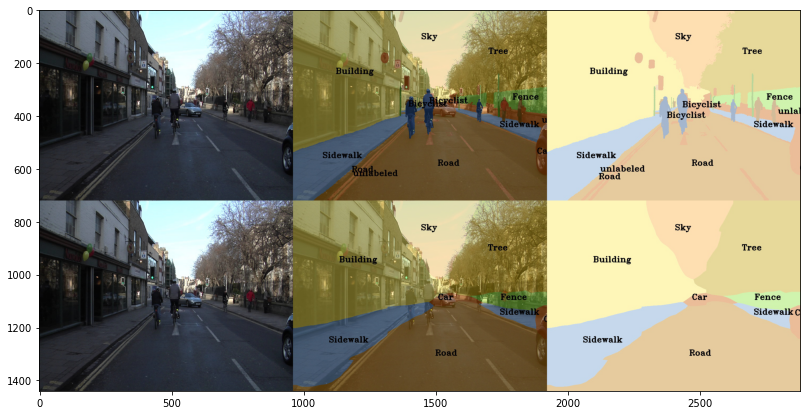

In [ ]:
import imageio
import matplotlib.pyplot as plt

rgb_predictions_dir = f"train_epoch_{args.epochs}/camvid-11/{args.base_size}/rgb_mask_predictions"

def show_image_grid(rgb_predictions_dir: str, img_fname: str) -> None:
  img_grid = imageio.imread(f'{rgb_predictions_dir}/{img_fname}')
  plt.figure(figsize=(15,7))
  plt.imshow(img_grid)
  plt.show()

show_image_grid(rgb_predictions_dir, "0016E5_07977.jpg")

In [ ]:
show_image_grid(rgb_predictions_dir, "0016E5_07997.jpg")
# show_image_grid(rgb_predictions_dir, "0016E5_08017.jpg")
show_image_grid(rgb_predictions_dir, "0016E5_08037.jpg")
# show_image_grid(rgb_predictions_dir, "0016E5_08057.jpg")
show_image_grid(rgb_predictions_dir, "0016E5_08077.jpg")
# show_image_grid(rgb_predictions_dir, "0016E5_08097.jpg")
show_image_grid(rgb_predictions_dir, "0016E5_08117.jpg")
# show_image_grid(rgb_predictions_dir, "0016E5_08137.jpg")
show_image_grid(rgb_predictions_dir, "0016E5_08157.jpg")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
grayscale_predictions_dir = f"train_epoch_{args.epochs}/camvid-11/{args.base_size}/gray"
!ls -ltrh $grayscale_predictions_dir
!zip -r grayscale_predictions.zip $grayscale_predictions_dir
!ls -ltrh grayscale_predictions.zip

total 714K
-rw------- 1 root root 6.3K Dec  8 17:43 0016E5_07967.png
-rw------- 1 root root 6.3K Dec  8 17:43 0016E5_07965.png
-rw------- 1 root root 6.6K Dec  8 17:43 0016E5_07963.png
-rw------- 1 root root 6.5K Dec  8 17:43 0016E5_07961.png
-rw------- 1 root root 6.5K Dec  8 17:43 0016E5_07959.png
-rw------- 1 root root 6.4K Dec  8 17:43 0016E5_07975.png
-rw------- 1 root root 6.3K Dec  8 17:43 0016E5_07973.png
-rw------- 1 root root 6.4K Dec  8 17:43 0016E5_07971.png
-rw------- 1 root root 6.2K Dec  8 17:43 0016E5_07969.png
-rw------- 1 root root 6.2K Dec  8 17:43 0016E5_07985.png
-rw------- 1 root root 6.1K Dec  8 17:43 0016E5_07983.png
-rw------- 1 root root 6.3K Dec  8 17:43 0016E5_07981.png
-rw------- 1 root root 6.1K Dec  8 17:43 0016E5_07979.png
-rw------- 1 root root 6.5K Dec  8 17:43 0016E5_07977.png
-rw------- 1 root root 6.4K Dec  8 17:43 0016E5_07993.png
-rw------- 1 root root 6.3K Dec  8 17:43 0016E5_07991.png
-rw------- 1 root root 6.4K Dec  8 17:43 0016E5_07989.png
-rw

In [ ]:
!python3 zip_submission.py --gt_username rzhang662@gatech.edu

Directory additional_data missing but optional, skipping.
